# Importing necessary library

In [1]:
import os
import cv2
import time
import keras
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

# Loading and processing the data

In [2]:
def load_and_process_data(directory):
    images = [] #empty list to hold the images
    labels = [] #empty list to hold the lables
    for root, dirs, files in os.walk(directory):
        f = os.path.basename(root)
        for file in files:
            try:
                img = cv2.imread(root+'/'+file)
                img = cv2.resize(img, (300,300))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.GaussianBlur(img, (5,5), 0)
                images.append(img)
                labels.append(f)
            except Exception:
                print('Error could not load all images')
    images = np.array(images)
    return (images, labels)

train_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/train"
validation_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation"

train_images, train_labels = load_and_process_data(train_path)
valid_images, valid_labels = load_and_process_data(validation_path)

# Visualization of the data

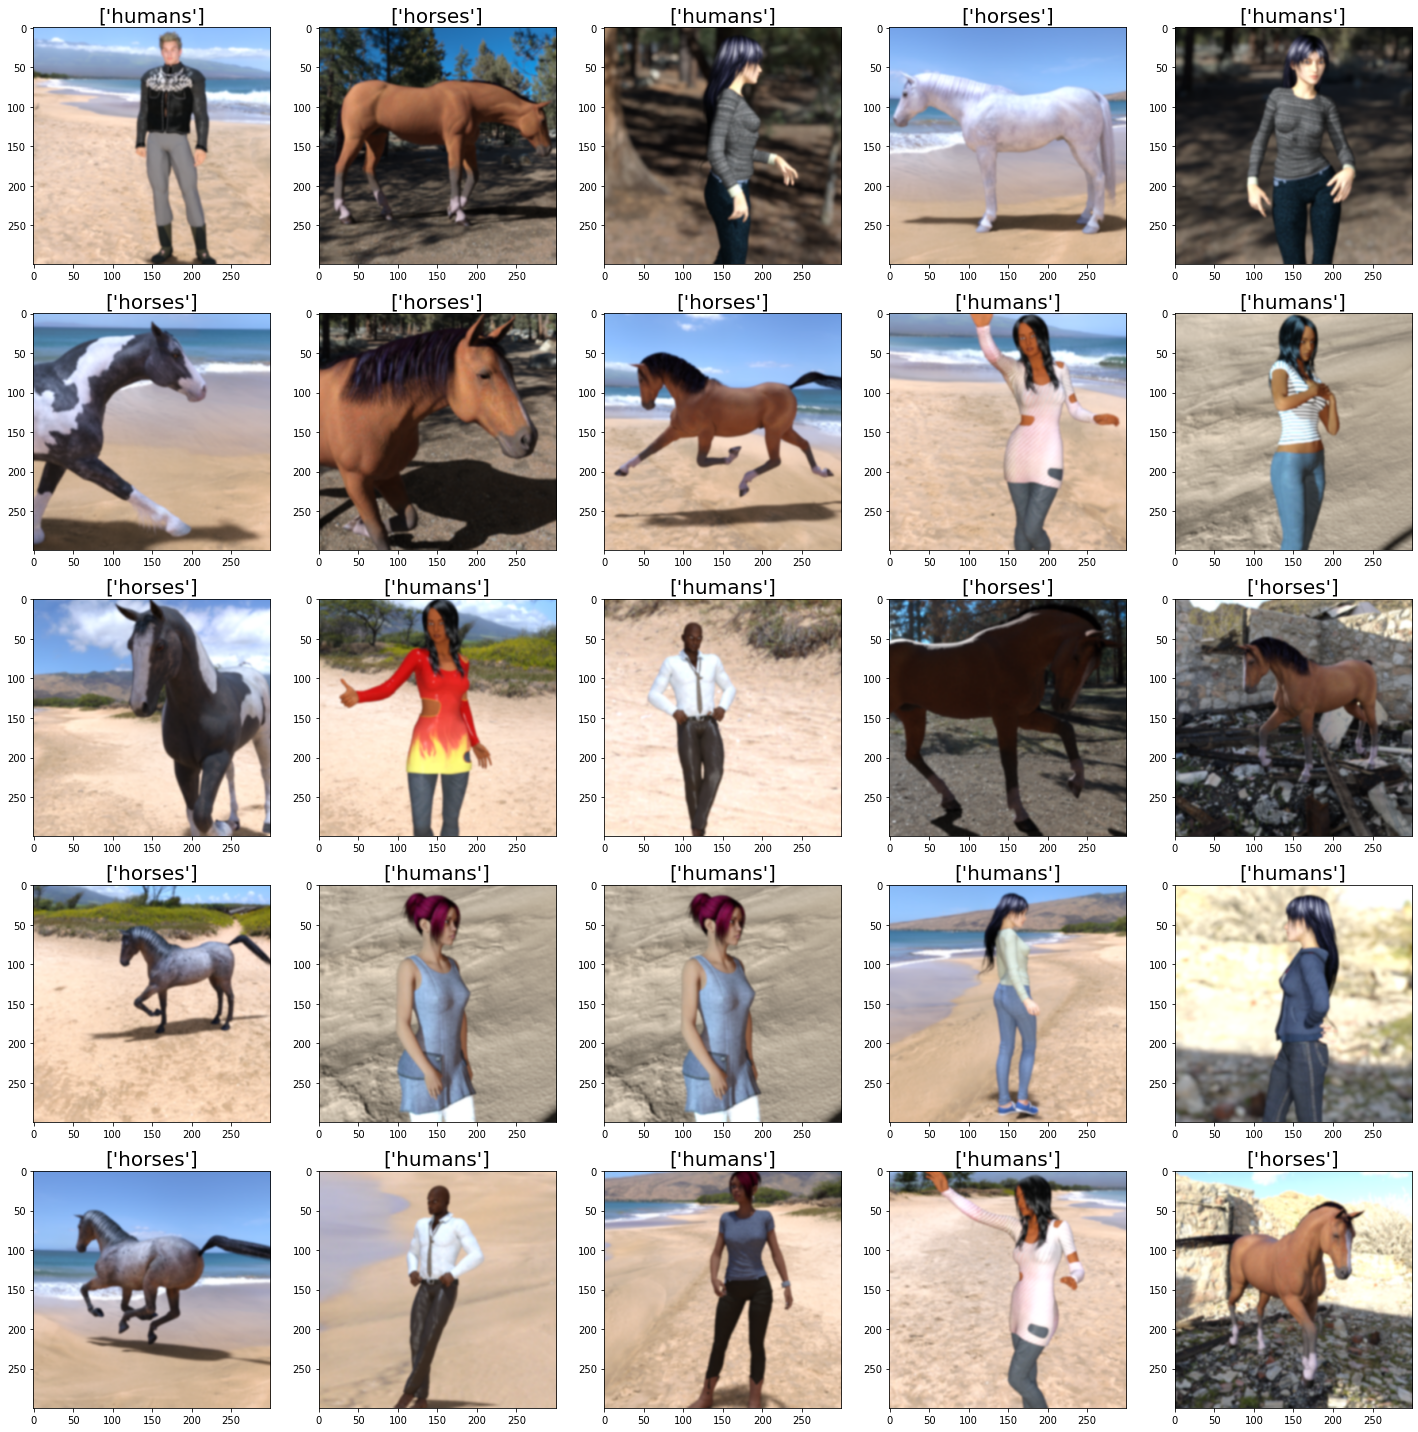

In [4]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(20,20)
for i in range(5):
    for j in range(5):
        num=np.random.randint(1,len(train_labels))
        ax[i,j].imshow(train_images[num])
        ax[i,j].set_title([train_labels[num]],size =20)
plt.tight_layout()

# Pre-Processing 

In [5]:
def preprocess_labels(labels):
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    labels = to_categorical(labels)
    labels = np.array(labels)
    labels = [int(i[0])for i in labels]
    return labels

train_labels_lst = preprocess_labels(train_labels)
valid_labels_lst = preprocess_labels(valid_labels)

# Train Test Split
train_images,test_images,train_labels_lst,test_labels_lst = train_test_split(train_images,train_labels_lst,test_size=0.25,random_state=20)


train_images = train_images / 255.0# Normalize Images
test_images = test_images / 255.0# Normalize Images
valid_images = valid_images / 255.0# Normalize Images
train_images.shape, test_images.shape, valid_images.shape

((770, 300, 300, 3), (257, 300, 300, 3), (256, 300, 300, 3))

# Data Augmentation

In [9]:
batch_size = 32
#tain data augmentation
train_data_aug = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator()
val_datagen = keras.preprocessing.image.ImageDataGenerator()

train_gen = train_data_aug.flow(train_images, train_labels_lst, batch_size=batch_size)
test_gen = test_datagen.flow(test_images, test_labels_lst, batch_size=batch_size)
valid_gen = val_datagen.flow(valid_images, valid_labels_lst, batch_size=batch_size,  shuffle=False)


# Custom CNN model

In [10]:
cnn_model = keras.models.Sequential()
cnn_model.add(Conv2D(128, (3,3), activation='relu',input_shape=(300,300,3)))
cnn_model.add(MaxPooling2D(3,3))

cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(256, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(512, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Conv2D(1028, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(2,2))

cnn_model.add(Flatten())
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.55))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 512)       1

#  Model compilation

In [13]:
# Compile Model
cnn_model.compile(optimizer=RMSprop(lr=0.00001),loss='binary_crossentropy',metrics=['acc'])

In [14]:
history = cnn_model.fit(train_gen,epochs=5,validation_data=test_gen)

Epoch 1/5
25/25 [==============================] - 327s 13s/step - loss: 0.6623 - acc: 0.6125 - val_loss: 0.6867 - val_acc: 0.5175
Epoch 2/5
25/25 [==============================] - 324s 13s/step - loss: 0.5474 - acc: 0.7578 - val_loss: 0.6794 - val_acc: 0.5720
Epoch 3/5
25/25 [==============================] - 324s 13s/step - loss: 0.5112 - acc: 0.7787 - val_loss: 0.6714 - val_acc: 0.6304
Epoch 4/5
25/25 [==============================] - 324s 13s/step - loss: 0.4666 - acc: 0.8247 - val_loss: 0.6574 - val_acc: 0.7588
Epoch 5/5
25/25 [==============================] - 325s 13s/step - loss: 0.4139 - acc: 0.8452 - val_loss: 0.6511 - val_acc: 0.6693


# Ploting Model loss

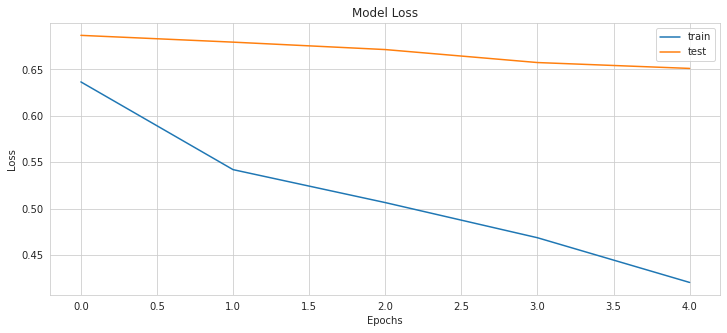

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# Ploting Model accuracy

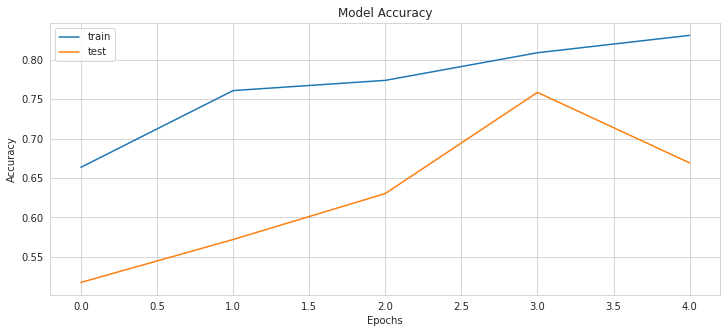

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [17]:
# Train data evaluation
train_score = cnn_model.evaluate_generator(train_gen)
# Test data evaluation
test_score = cnn_model.evaluate_generator(test_gen)
# Validation data evaluation
valid_score = cnn_model.evaluate_generator(valid_gen)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [18]:
print("Train_Accuracy = ",train_score[1])
print("Test_Accuracy = ",test_score[1])
print("Validation_Accuracy = ",valid_score[1])

Train_Accuracy =  0.6571428775787354
Test_Accuracy =  0.6692606806755066
Validation_Accuracy =  0.50390625
